## Launch preparation

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from torch import nn,manual_seed,from_numpy, split, tensor
import torch.optim as optim
import torch
import time
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib


def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


set_random_seed(42)

In [2]:
!pip install torcheval
from torcheval.metrics import MulticlassF1Score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## Loading data

In [21]:
DataNPY = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/OpenDataset_20k_Noise1per.npy",allow_pickle=True)

In [22]:
def normOfDataset(vector):
  vector[0] = (vector[0]+np.pi)/(2*np.pi)
  vector[2] = (vector[2]+np.pi)/(2*np.pi)
  vector[3] = (vector[3])/(2*np.pi)
  vector[5] = (vector[5])/(2*np.pi)
  vector[4] = (vector[4]+1)/2
  return vector

class GPDataset(Dataset):
    def __init__(self, GPdata):
      self.GPdata = []
      for obj in tqdm(GPdata):
        self.GPdata.append((tensor(obj[0]),tensor(obj[1]),tensor(normOfDataset(obj[2]))))

    def __len__(self):
      return len(self.GPdata)

    def __getitem__(self, idx):
      return self.GPdata[idx][0],self.GPdata[idx][1],self.GPdata[idx][2]




In [29]:

# Length of training and testing samples
lenTestData = 10000
lenTrainData = 10000
batch_size = 5000

testDatasets = GPDataset(DataNPY[:lenTestData])
trainDatasets = GPDataset(DataNPY[lenTestData:lenTestData+lenTrainData])

testDataloader = DataLoader(testDatasets, batch_size=batch_size, shuffle=False, num_workers=2)
trainDataloader = DataLoader(trainDatasets, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 10000/10000 [00:00<00:00, 12984.42it/s]


## Model structure

In [7]:
def outputLaeyrs(otput, lenOfFirstLayer = 700,lenOfSecondLayer = 70, nonlinearity = nn.ReLU, mod = 'classifier'):
  seq = nn.Sequential(nn.Linear(lenOfFirstLayer, lenOfSecondLayer, bias=False),
                      nn.BatchNorm1d(lenOfSecondLayer),
                      nonlinearity(),
                      nn.Linear(lenOfSecondLayer, otput))
  if mod == 'classifier':
    seq.append(nn.Sigmoid())
  return seq


embSeq_base = nn.Sequential(
     nn.Linear(5, 200, bias=False),
     nn.BatchNorm1d(200),
     nn.ReLU(),
     nn.Linear(200, 2000, bias=False),
     nn.BatchNorm1d(2000),
     nn.ReLU(),
     nn.Linear(2000, 4000, bias=False),
     nn.BatchNorm1d(4000),
     nn.ReLU(),
     nn.Linear(4000, 700, bias=False),
     nn.BatchNorm1d(700),
     nn.ReLU()
)


regrSeq_base = nn.Sequential(
     nn.Linear(700, 1500, bias=False),
     nn.BatchNorm1d(1500),
     nn.ReLU(),
     nn.Linear(1500, 700, bias=False),
     nn.BatchNorm1d(700),
     nn.ReLU()
)


In [8]:
class GPNN_v1(nn.Module):
  def __init__(self, SeqEmbedding = embSeq_base, SeqRegression = regrSeq_base, init_form = "normal"):
    super().__init__()
    self.embedding_stack = SeqEmbedding
    self.regression_stack = SeqRegression

    self.classifierLAA = outputLaeyrs(1); self.classifierLPA = outputLaeyrs(1)
    self.classifierCAA = outputLaeyrs(1); self.classifierCPA = outputLaeyrs(1)

    #self.regressionT = outputLaeyrs(1, mod = 0)
    self.regressionP = outputLaeyrs(1, mod = 0)
    self.regressionTheta = outputLaeyrs(1, mod = 0)
    self.regressionDelta = outputLaeyrs(1, mod = 0)
    self.regressionPhi = outputLaeyrs(1, mod = 0)
    self.regressionCAA = outputLaeyrs(1, mod = 0)
    self.regressionCPA = outputLaeyrs(1, mod = 0)

    self.init_form = init_form
    if self.init_form is not None:
      self.init()


  def forward(self, x, mod = 'NoTrain', classVectors = np.nan):
    emb = self.embedding_stack(x)
    if mod == 'classifier':
      return self.classifierLAA(emb),self.classifierLPA(emb),\
            self.classifierCAA(emb),self.classifierCPA(emb)

    if mod == 'regression':
      outReg = self.regression_stack(emb)
      return self.regressionP(outReg),self.regressionTheta(outReg),self.regressionDelta(outReg),\
              self.regressionPhi(outReg), self.regressionCAA(outReg), self.regressionCPA(outReg)

    if mod == 'NoTrain':
      outReg = self.regression_stack(emb)
      return self.classifierLAA(emb),self.classifierLPA(emb), self.classifierCAA(emb),\
        self.classifierCPA(emb), self.regressionP(outReg),\
          self.regressionTheta(outReg), self.regressionDelta(outReg), self.regressionPhi(outReg),\
            self.regressionCAA(outReg), self.regressionCPA(outReg)



  def init(self):
    relu_gain = torch.nn.init.calculate_gain("relu")
    for child in self.embedding_stack.children():
      if isinstance(child, nn.Linear):
        if self.init_form == "normal":
          torch.nn.init.kaiming_normal_(child.weight, nonlinearity='relu')
          if child.bias is not None: torch.nn.init.zeros_(child.bias)
        elif self.init_form == "uniform":
          torch.nn.init.kaiming_uniform_(child.weight,nonlinearity='relu')
          if child.bias is not None:torch.nn.init.zeros_(child.bias)
        else:
          raise NotImplementedError()

    for child in self.regression_stack.children():
      if isinstance(child, nn.Linear):
        if self.init_form == "normal":
          torch.nn.init.kaiming_normal_(child.weight, nonlinearity='relu')
          if child.bias is not None: torch.nn.init.zeros_(child.bias)
        elif self.init_form == "uniform":
          torch.nn.init.kaiming_uniform_(child.weight,nonlinearity='relu')
          if child.bias is not None:torch.nn.init.zeros_(child.bias)
        else:
          raise NotImplementedError()


## Functions for training

In [9]:
def lossClassifierGP(criterion,predict,original):
  criterion = criterion()
  total_loss = criterion(predict[0],original[:,0].reshape(-1,1))+criterion(predict[1],original[:,1].reshape(-1,1))+\
  criterion(predict[2],original[:,2].reshape(-1,1))+criterion(predict[3],original[:,3].reshape(-1,1))
  return total_loss

In [10]:
def f1_calc(tensorOne,tensorTwo,device):
  metric = MulticlassF1Score(num_classes=2).to(device)
  metric.update(tensorOne.reshape(-1).detach().round(),tensorTwo.detach().round())
  return metric.compute().item()


def accClassifierGP(model,localData,device):
  accLAA,accLPA,accCAA,accCPA =0.,0.,0.,0.
  model.eval()
  metric = MulticlassF1Score(num_classes=2)
  with torch.no_grad():
    for corrFunc, classVectors, _ in localData:
      corrFunc, classVectors = corrFunc.to(device), classVectors.to(device)
      predict = model(corrFunc,mod = 'classifier')
      accLAA = accLAA + f1_calc(predict[0],classVectors[:,0],device)
      accLPA = accLPA + f1_calc(predict[1],classVectors[:,1],device)
      accCAA = accCAA + f1_calc(predict[2],classVectors[:,2],device)
      accCPA = accCPA + f1_calc(predict[3],classVectors[:,3],device)
  localLen = len(localData)
  return accLAA/localLen,accLPA/localLen,accCAA/localLen,accCPA/localLen

In [11]:
def trainGPNNClassifier(model, trainloader,testloader,device = 'cpu', num_epochs = 2, criterion = nn.BCELoss,\
              optimizer = optim.Adam,learning_rate = 0.001,save_state = True):


    optimizer = optimizer(model.parameters(), lr=learning_rate)
    num_epochs = num_epochs
    loss_hist_train = [] # for plotting
    loss_hist_test = []
    accTrainLAA,accTrainLPA,accTrainCAA,accTrainCPA = [],[],[],[]
    accTestLAA,accTestLPA,accTestCAA,accTestCPA = [],[],[],[]

    for epoch in tqdm(range(num_epochs)):
        #training

        hist_loss = 0
        model.train()
        for corrFunc, classVectors, _ in trainloader:
            classVectors = classVectors.float()
            corrFunc, classVectors = corrFunc.to(device), classVectors.to(device)
            optimizer.zero_grad()
            loss = lossClassifierGP(criterion, model(corrFunc,mod = 'classifier'), classVectors)
            loss.backward()
            optimizer.step()
            hist_loss += loss.item()
        loss_hist_train.append(hist_loss /len(trainloader))



        accLAA,accLPA,accCAA,accCPA = accClassifierGP(model,trainloader,device)
        accTrainLAA.append(accLAA);accTrainLPA.append(accLPA)
        accTrainCAA.append(accCAA);accTrainCPA.append(accCPA)


        # testdata
        model.eval()
        test_loss = 0
        numBatch = 0
        with torch.no_grad():
          for corrFunc, classVectors, _ in testloader:
            classVectors = classVectors.float()
            corrFunc, classVectors = corrFunc.to(device), classVectors.to(device)
            loss = lossClassifierGP(criterion, model(corrFunc,mod = 'classifier'), classVectors)
            test_loss += loss.item()
        loss_hist_test.append(test_loss/len(testloader))

        accLAA,accLPA,accCAA,accCPA = accClassifierGP(model,testloader,device)
        accTestLAA.append(accLAA);accTestLPA.append(accLPA)
        accTestCAA.append(accCAA);accTestCPA.append(accCPA)


        if epoch%9 == 0: print(f"Epoch={epoch} loss_train={loss_hist_train[epoch]:.5f} loss_test={loss_hist_test[epoch]:.5f}")
        if save_state:
          os.makedirs('check_points_c', exist_ok=True)
          torch.save(model.state_dict(), f'check_points_c/fine_tuning_classifaer_{epoch}.pth')
    return loss_hist_train,loss_hist_test,\
      [accTrainLAA,accTrainLPA,accTrainCAA,accTrainCPA],[accTestLAA,accTestLPA,accTestCAA,accTestCPA]

In [12]:
def accRegressor(model,localData,device):
  loss_P, loss_Theta = 0., 0.
  loss_Delta, loss_Phi  = 0., 0.
  loss_CAA, loss_CPA = 0.,0.
  #loss_T = 0.

  model.eval()
  with torch.no_grad():
    for corrFunc, _, parameters in localData:
      corrFunc, parameters = corrFunc.to(device), parameters.to(device)
      predict = model(corrFunc, mod = 'regression')

      #loss_T = loss_T + (abs(predict[0]-parameters[:,0])).mean().item()

      predTheta = predict[0][~torch.any(torch.unsqueeze(parameters[:,0],1).isnan(),dim=1)]
      paramTheta  = torch.unsqueeze(parameters[:,0],1)[~torch.any(torch.unsqueeze(parameters[:,0],1).isnan(),dim=1)]
      loss_Theta = loss_Theta + abs(predTheta-paramTheta).mean().item()

      predP = predict[1][~torch.any(torch.unsqueeze(parameters[:,1],1).isnan(),dim=1)]
      paramP = torch.unsqueeze(parameters[:,1],1)[~torch.any(torch.unsqueeze(parameters[:,1],1).isnan(),dim=1)]
      loss_P = loss_P + abs(predP-paramP).mean().item()

      predPhi = predict[2][~torch.any(torch.unsqueeze(parameters[:,2],1).isnan(),dim=1)]
      paramPhi = torch.unsqueeze(parameters[:,2],1)[~torch.any(torch.unsqueeze(parameters[:,2],1).isnan(),dim=1)]
      loss_Phi = loss_Phi + abs(predPhi-paramPhi).mean().item()


      predDelta = predict[3][~torch.any(torch.unsqueeze(parameters[:,3],1).isnan(),dim=1)]
      paramDelta = torch.unsqueeze(parameters[:,3],1)[~torch.any(torch.unsqueeze(parameters[:,3],1).isnan(),dim=1)]
      loss_Delta = loss_Delta + abs(predDelta-paramDelta).mean().item()


      predCAA = predict[4][~torch.any(torch.unsqueeze(parameters[:,4],1).isnan(),dim=1)].to(device)
      paramCAA = torch.unsqueeze(parameters[:,4],1)[~torch.any(torch.unsqueeze(parameters[:,4],1).isnan(),dim=1)].to(device)
      loss_CAA = loss_CAA + (abs(predCAA-paramCAA)).mean().item()


      predCPA = predict[5][~torch.any(torch.unsqueeze(parameters[:,5],1).isnan(),dim=1)].to(device)
      paramCPA = torch.unsqueeze(parameters[:,5],1)[~torch.any(torch.unsqueeze(parameters[:,5],1).isnan(),dim=1)].to(device)

      loss_CPA = loss_CPA + (abs(predCPA-paramCPA)).mean().item()

  return loss_P/len(parameters),loss_Theta/len(parameters),loss_Delta/len(parameters),loss_Phi/len(parameters),\
        loss_CAA/len(parameters),loss_CPA/len(parameters)

In [13]:
def lossRegressionGP(criterion,predict,parameters):
  criterion = criterion()

  predTheta = predict[0][~torch.any(torch.unsqueeze(parameters[:,0],1).isnan(),dim=1)]
  paramTheta = torch.unsqueeze(parameters[:,0],1)[~torch.any(torch.unsqueeze(parameters[:,0],1).isnan(),dim=1)]

  predP = predict[1][~torch.any(torch.unsqueeze(parameters[:,1],1).isnan(),dim=1)]
  paramP  = torch.unsqueeze(parameters[:,1],1)[~torch.any(torch.unsqueeze(parameters[:,1],1).isnan(),dim=1)]

  predDelta = predict[2][~torch.any(torch.unsqueeze(parameters[:,2],1).isnan(),dim=1)]
  paramPDelta = torch.unsqueeze(parameters[:,2],1)[~torch.any(torch.unsqueeze(parameters[:,2],1).isnan(),dim=1)]

  predPhi = predict[3][~torch.any(torch.unsqueeze(parameters[:,3],1).isnan(),dim=1)]
  paramPhi = torch.unsqueeze(parameters[:,3],1)[~torch.any(torch.unsqueeze(parameters[:,3],1).isnan(),dim=1)]

  predCAA = predict[4][~torch.any(torch.unsqueeze(parameters[:,4],1).isnan(),dim=1)]
  paramCAA = torch.unsqueeze(parameters[:,4],1)[~torch.any(torch.unsqueeze(parameters[:,4],1).isnan(),dim=1)]

  predCPA = predict[5][~torch.any(torch.unsqueeze(parameters[:,5],1).isnan(),dim=1)]
  paramCPA = torch.unsqueeze(parameters[:,5],1)[~torch.any(torch.unsqueeze(parameters[:,5],1).isnan(),dim=1)]

  total_loss = criterion(predP,paramP) + criterion(predTheta,paramTheta) + \
        criterion(predPhi,paramPhi) + criterion(predDelta,paramPDelta) + \
        criterion(predCAA,paramCAA) + criterion(predCPA,paramCPA) # + criterion(predict[0],torch.unsqueeze(parameters[:,0],1))
  return total_loss

In [14]:
def trainGPNNRegressor(model, trainloader,testloader,device = 'cpu', num_epochs = 2, criterion = nn.MSELoss,\
              optimizer = optim.Adam,learning_rate = 0.001, save_state = False):

    # freezing
    for param in model.embedding_stack.parameters():
      param.requires_grad = False


    optimizer = optimizer(model.parameters(), lr=learning_rate)
    num_epochs = num_epochs
    loss_hist_train = [] # for plotting
    loss_hist_test = []
    accTrainP,accTrainTheta,accTrainPhi,accTrainDelta = [],[],[],[]
    accTestP,accTestTheta,accTestPhi,accTestDelta = [],[],[],[]
    accTrainR, accTrainKsi = [],[]
    accTestR, accTestKsi = [],[]
    accTrainT = []
    accTestT = []

    for epoch in tqdm(range(num_epochs)):
        # learning

        hist_loss = 0
        model.train()
        for corrFunc, _, parameters in trainloader:
            corrFunc, parameters = corrFunc.to(device), parameters.to(device)
            optimizer.zero_grad()
            loss = lossRegressionGP(criterion, model(corrFunc,mod = 'regression'), parameters)
            loss.backward()
            optimizer.step()
            hist_loss += loss.item()
        loss_hist_train.append(hist_loss /len(trainloader))

        accP,accTheta,accPhi,accDelta,accR,accKsi = accRegressor(model,trainloader,device)
        accTrainP.append(accP);accTrainTheta.append(accTheta)
        accTrainPhi.append(accPhi);accTrainDelta.append(accDelta)
        accTrainKsi.append(accKsi);accTrainR.append(accR)


        # testdata
        model.eval()
        test_loss = 0
        numBatch = 0
        with torch.no_grad():
          for corrFunc, _,parameters in testloader:
            corrFunc, parameters = corrFunc.to(device), parameters.to(device)
            loss = lossRegressionGP(criterion, model(corrFunc,mod = 'regression'), parameters)
            test_loss += loss.item()
        loss_hist_test.append(test_loss/len(testloader))

        accP,accTheta,accPhi,accDelta,accR,accKsi = accRegressor(model,testloader,device)
        accTestP.append(accP);accTestTheta.append(accTheta)
        accTestPhi.append(accPhi);accTestDelta.append(accDelta)
        accTestKsi.append(accKsi);accTestR.append(accR)


        if epoch%9 == 0: print(f"Epoch={epoch} loss_train={loss_hist_train[epoch]:.5f} loss_test={loss_hist_test[epoch]:.5f}")

        if save_state:
          os.makedirs('check_points_r', exist_ok=True)
          torch.save(model.state_dict(), f'check_points_r/fine_tuning_regressor_{epoch + 1}.pth')
    return loss_hist_train,loss_hist_test,\
      [accTrainP,accTrainTheta,accTrainPhi,accTrainDelta,accTrainR,accTrainKsi],\
      [accTestP,accTestTheta,accTestPhi,accTestDelta,accTestR,accTestKsi]

## Learning

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [25]:
set_random_seed(42)

model = GPNN_v1().to(device)
model = model.float()
time_0 = time.time()
num_epochs_c = 30
loss_train, loss_test, acc_test, acc_train = trainGPNNClassifier(model,trainDataloader, testDataloader,\
                      num_epochs = num_epochs_c, criterion = nn.BCELoss ,learning_rate = 0.001, device = device)
print("Duration:", time.time()-time_0)

  3%|▎         | 1/30 [00:03<01:32,  3.18s/it]

Epoch=0 loss_train=1.45278 loss_test=3.14035


 33%|███▎      | 10/30 [00:16<00:25,  1.26s/it]

Epoch=9 loss_train=0.41319 loss_test=0.36202


 63%|██████▎   | 19/30 [00:29<00:13,  1.25s/it]

Epoch=18 loss_train=0.32787 loss_test=0.32110


 90%|█████████ | 27/30 [00:39<00:03,  1.29s/it]

Epoch=27 loss_train=0.26922 loss_test=0.23536


100%|██████████| 30/30 [00:43<00:00,  1.46s/it]

Duration: 43.72459292411804


In [17]:
def searchOfbestClassifaer(acc_arr,num_epochs):
  bestAcc = 0
  bestEpoch = 0
  for i in range(num_epochs):
    totalAcc = acc_arr[0][i]*acc_arr[1][i]*acc_arr[2][i]*acc_arr[3][i]
    if totalAcc > bestAcc:
      bestAcc = totalAcc
      bestEpoch = i
  return bestEpoch

str(searchOfbestClassifaer(acc_test,num_epochs_c))

'32'

In [ ]:
set_random_seed(42)



path_to_load = 'check_points_c/fine_tuning_classifaer_'+str(searchOfbestClassifaer(acc_test,num_epochs_c))+'.pth'
model.load_state_dict(torch.load(path_to_load))

loss_trainR, loss_testR, acc_testR, acc_trainR = trainGPNNRegressor(model,trainDataloader, testDataloader,\
                      num_epochs = 25, learning_rate = 0.0001, criterion = nn.MSELoss, device = device, save_state = True)


  4%|▍         | 1/25 [00:00<00:21,  1.14it/s]

Epoch=0 loss_train=1.89503 loss_test=2.21024


 40%|████      | 10/25 [00:08<00:12,  1.16it/s]

Epoch=9 loss_train=0.16488 loss_test=0.16212


 76%|███████▌  | 19/25 [00:16<00:05,  1.18it/s]

Epoch=18 loss_train=0.14015 loss_test=0.17430


100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


In [ ]:
np.save("loss_acc", [loss_train, loss_test, acc_test, acc_train, loss_trainR, loss_testR, acc_testR, acc_trainR])

## Vizualization

In [26]:
def plotLoss(localtest, localtrain, name, mod ):
  #mod = "C" or "R"
  fig, ax = plt.subplots()
  matplotlib.rcParams.update({'font.size': 12})
  ax.plot(localtrain, linestyle='-', marker='o', color='k',
         markerfacecolor='#ff00aaff', label='Train datset')
  ax.plot(localtest, linestyle='--', marker='o', color='b',
         markerfacecolor='#00ffffff',  label='Test dataset')
  ax.legend(fontsize=16)
  ax.minorticks_on()
  ax.set_xlabel('Epoch number', fontsize=16)
  if mod == 'R' : ax.set_ylabel(r'Loss of $Regression$ $stack$', fontsize=16)
  if mod == 'C' : ax.set_ylabel(r'Loss of $Classifier$ $stack$', fontsize=16)
  #plt.xlim([-1., 1.])
  #plt.ylim([-1., 1.])
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  plt.tight_layout()
  fig.savefig(name + ".png",dpi = 300)
  fig.show()

def plotAccClass(localtest, localtrain,name):
  fig, ax = plt.subplots()
  matplotlib.rcParams.update({'font.size': 12})
  ax.plot(localtest[0],color='r', linestyle='-',label='F1-score LA - test dataset')
  ax.plot(localtest[1],color='b', linestyle='--',label='F1-score LP - test dataset')
  ax.plot(localtest[2],color='#920087ff', linestyle='dotted',label='F1-score CA - test dataset')
  ax.plot(localtest[3],color='#004e00ff',linestyle='dashdot',label='F1-score CP - test dataset')
  ax.plot(localtrain[0],"o",color='#ffd4e9',label='F1-score LA - train dataset',markersize=8)
  ax.plot(localtrain[1],"P",color='#00ffffff',label='F1-score LP - train dataset',markersize=8)
  ax.plot(localtrain[2],"^",color='#a57cffff',label='F1-score CA - train dataset',markersize=8)
  ax.plot(localtrain[3],"*",color='#51de00ff',label='F1-score CP - train dataset',markersize=8)
  ax.set_xlabel('Epoch number', fontsize=16)
  ax.set_ylabel("F1-score", fontsize=16)
  ax.legend()
  ax.minorticks_on()
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  plt.tight_layout()
  fig.savefig(name + ".png",dpi = 300)
  ax.legend(loc='lower right', borderaxespad=0.)
  fig.show()

def plotAccR(localtest, localtrain, name):
  fig, ax = plt.subplots()
  matplotlib.rcParams.update({'font.size': 12})
  ax.plot(localtrain[0],linestyle='--',label='Test \u03B8')
  ax.plot(localtrain[1],linestyle='--',label='Test P')
  ax.plot(localtrain[2],linestyle='--',label='Test \u03B1')
  ax.plot(localtrain[3],linestyle='--',label='Test \u0394')
  ax.plot(localtrain[4],linestyle='--',label='Test R')
  ax.plot(localtrain[5],linestyle='--',label='Test \u03D5')
  ax.plot(localtest[0],"o",label='Train \u03B8')
  ax.plot(localtest[1],"o",label='Train P')
  ax.plot(localtest[2],"o",label='Train \u03B1')
  ax.plot(localtest[3],"o",label='Train \u0394')
  ax.plot(localtest[4],"o",label='Train R')
  ax.plot(localtest[5],"o",label='Train \u03D5')

  ax.set_xlabel('Epoch number', fontsize=16)
  ax.set_ylabel("Mean absolute error", fontsize=16)
  ax.legend()
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  plt.tight_layout()
  fig.savefig(name + ".png",dpi = 300)
  ax.legend(bbox_to_anchor=(1.05, 1),
                         loc='lower right', borderaxespad=0.)
  fig.show()

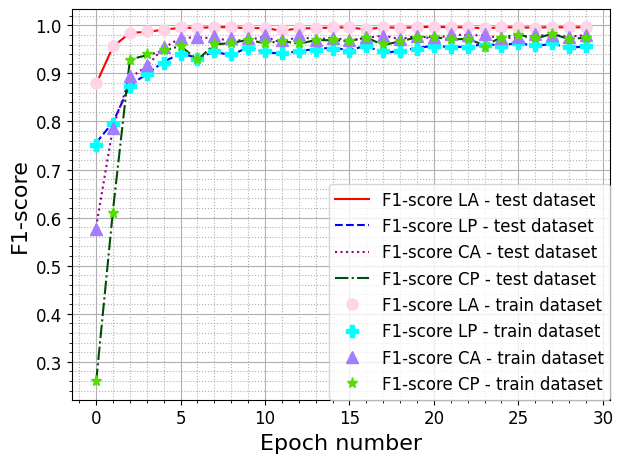

In [27]:
plotAccClass(acc_test,acc_train,'Acc_Cl')

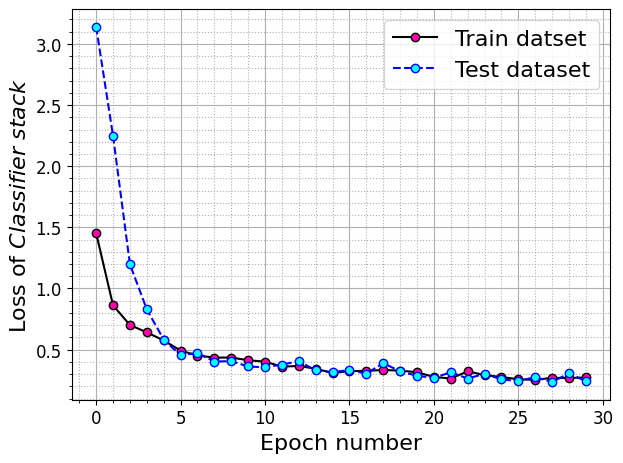

In [28]:
#plotLoss(loss_testR,loss_trainR, 'Fig_loss_R', mod = 'R')
plotLoss(loss_test,loss_train, 'Fig_loss_C', mod = 'C')

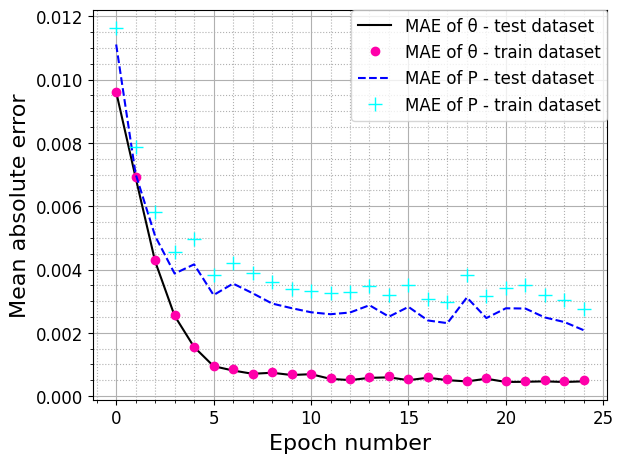

In [ ]:
def plotAccR_LAA(localtest, localtrain, name):
  fig, ax = plt.subplots()
  matplotlib.rcParams.update({'font.size': 12})
  ax.plot(localtest[1],color='k', linestyle='-',label='MAE of \u03B8 - test dataset')
  ax.plot(localtrain[1],"o",color='#ff00aaff', label='MAE of \u03B8 - train dataset')
  ax.plot(localtest[0],color='b',linestyle='--',label='MAE of P - test dataset')

  ax.plot(localtrain[0],"+",color = '#00ffffff', label='MAE of P - train dataset',markersize = 10)

  ax.set_xlabel('Epoch number', fontsize=16)
  ax.set_ylabel("Mean absolute error", fontsize=16)
  ax.legend()
  ax.minorticks_on()
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  plt.tight_layout()
  fig.savefig(name + ".png",dpi = 300)
  ax.legend(
                         loc='upper right', borderaxespad=0.)
  fig.show()

plotAccR_LAA(acc_testR,acc_trainR,'Fig_acc_R_LAA')

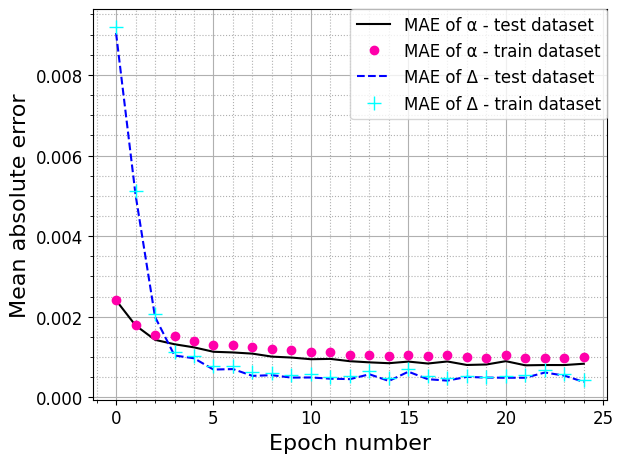

In [ ]:
def plotAccR_LPA(localtest, localtrain, name):
  fig, ax = plt.subplots()
  matplotlib.rcParams.update({'font.size': 12})
  ax.plot(localtest[2],color='k', linestyle='-',label='MAE of \u03B1 - test dataset')
  ax.plot(localtrain[2],"o",color='#ff00aaff', label= 'MAE of \u03B1 - train dataset')
  ax.plot(localtest[3],color='b',linestyle='--',label='MAE of \u0394 - test dataset')
  ax.plot(localtrain[3],"+",color = '#00ffffff', label='MAE of \u0394 - train dataset',markersize = 10)

  ax.set_xlabel('Epoch number', fontsize=16)
  ax.set_ylabel("Mean absolute error", fontsize=16)
  ax.legend()
  ax.minorticks_on()
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  plt.tight_layout()
  fig.savefig(name + ".png",dpi = 300)
  ax.legend(loc='upper right', borderaxespad=0.)
  fig.show()

plotAccR_LPA(acc_testR,acc_trainR,'Fig_acc_R_LPA')

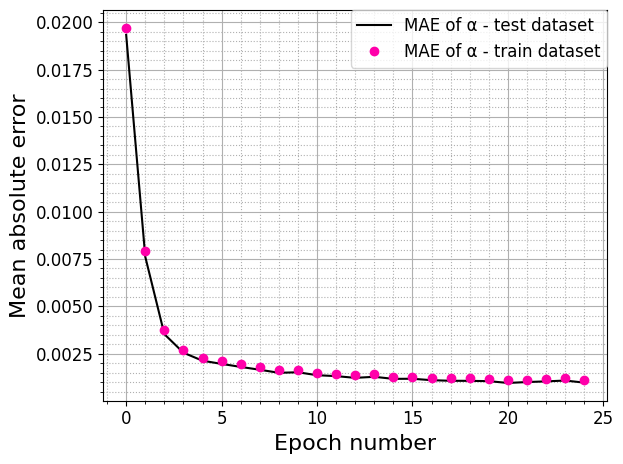

In [ ]:
def plotAccR_LPA(localtest, localtrain, name):
  fig, ax = plt.subplots()
  matplotlib.rcParams.update({'font.size': 12})
  ax.plot(localtest[4],color='k', linestyle='-',label='MAE of R - test dataset')
  ax.plot(localtrain[4],"o",color='#ff00aaff', label='MAE of R - train dataset')

  ax.set_xlabel('Epoch number', fontsize=16)
  ax.set_ylabel("Mean absolute error", fontsize=16)
  ax.legend()
  ax.minorticks_on()
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  plt.tight_layout()
  fig.savefig(name + ".png",dpi = 300)
  ax.legend(loc='upper right', borderaxespad=0.)
  fig.show()

plotAccR_LPA(acc_testR,acc_trainR,'Fig_acc_R_CAA')

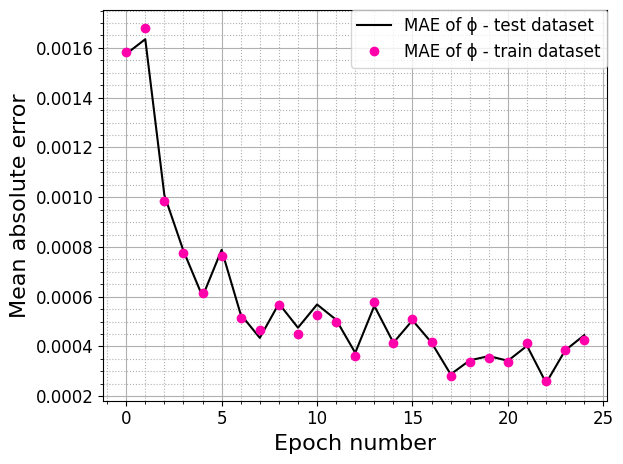

In [ ]:
def plotAccR_LPA(localtest, localtrain, name):
  fig, ax = plt.subplots()
  matplotlib.rcParams.update({'font.size': 12})
  ax.plot(localtest[5],color='k', linestyle='-',label='MAE of \u03D5 - test dataset')
  ax.plot(localtrain[5],"o",color='#ff00aaff', label='MAE of \u03D5 - train dataset')

  ax.set_xlabel('Epoch number', fontsize=16)
  ax.set_ylabel("Mean absolute error", fontsize=16)
  ax.legend()
  ax.minorticks_on()
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  plt.tight_layout()
  fig.savefig(name + ".png",dpi = 300)
  ax.legend(loc='upper right', borderaxespad=0.)
  fig.show()

plotAccR_LPA(acc_testR,acc_trainR,'Fig_acc_R_CPA')